# Graph Attention Networks


- can be used on arbitrariy structured graphs, such as biological, telecommunication or social networks.
- are able to process both directed and undirected graphs

1. iterative process for propagating the node states across the graph until equilibrum
2. neural network -> output for each node based on its state


### Attention mechanisms

- focus on the most relevant parts of the variable sized input
- self-attention enables the model to weigh the importance of different elements in an input sequence and dynamically adjust their influence on the output
- this principe is used to compute the hidden representation of each node in the graph, taking in the information of its neighbours

Advantages:
- parallelizable across neighbours
- can be applied to graph nodes with different degrees
- can be used as a solution to an inductive learning problem because of the model's ability to generalize to completely unseen graphs

## GAT Attentional Layer

1. **Input** - a set of node features

$$
\displaystyle\ \bold{h}=\{ \vec{h_1},  \vec{h_2},  \dots ,  \vec{h_N} \}, \vec{h_i} \in \mathbb{R}^F
$$

where $N$ is the number of nodes and $F$ the number of features for each node.

2. **Ouput** - a new set of node features of a potentially different cardinality

$$
\displaystyle\ \bold{h'}=\{ \vec{h'_1},  \vec{h'_2},  \dots ,  \vec{h'_N} \}, \vec{h'_i} \in \mathbb{R}^{F'}
$$

![alt text](<Screenshot 2024-05-27 164332.png>)

Considering a node $i$ and its neighbours $j \in \mathcal{N_i}$, the new node embeddings, $h_i'$, are obtained as follows:
* The adjaceny matrix acts as a mask, allowing only the neighbours' embeddings to be taken into consideration
* Then, the embeddings are processed through a single-layer feedforward neural network. The matrix W is a trainable parameter that transforms the node's embeddings. Also, depending of its shape, the ouput embeddings may have a different cardinality, $F'$.
* Each pair $(i, j)$ has an associated attention coefficient $\bold{\alpha_{ij}}$, allowing for a differentiated treatment of the neighbours' influence on the new embedding $h_i'$.
* Afterwards, the transformed embeddings for each neighbour, $\bold W h_j$, are summed up and an activation function is applied. Usually, the employed nonlinearity is ELU (Exponential Linear Unit).

## The Attention Mechanism

$$

\vec{h'_i}=\sigma(\sum_{j \in \mathcal N_i} \alpha_{ij} \bold W \vec{h_j})
$$


The attention coefficient $a : \mathbb{R}^{F'} \times \mathbb{R}^{F'} \to \mathbb{R}$ is computed in the following manner:
* The transformed embedding for node $i$ is concatenated in turn with each of its neighbours' transformed embedding.
* The input matrix $[\bold W \vec{h_i}\|\bold W \vec{h_j}]$ is linearly transformed using the learned parameter $a^T$, the attention vector, obtaining the coefficient $e_{ij}$.

$$
e_{ij}=a(\bold W \vec{h'_i}, \bold W \vec{h'_j})
$$

![alt text](<Screenshot 2024-05-27 165728-1.png>)

* Then, LeakyReLU is applied to the $e_{ij}$ coefficient, followed by softmax obtain the normalized attention coefficent $\bold{\alpha_{ij}}$.

$$
\alpha_{ij}=softmax_j(e_{ij})=\frac{exp(e_{ij})}{\sum_{k \in \mathcal{N}_i} exp(e_{ik})}
$$

$$
\alpha_{ij}=\frac{exp(LeakyReLU(\bold{\vec{a}}^T[\bold W \vec{h_i}\|\bold W \vec{h_j}]))}{\sum_{k \in \mathcal{N}_i} exp(LeakyReLU(\bold{\vec{a}}^T[\bold W \vec{h_i}\|\bold W \vec{h_k}]))}
$$

## Multi-head Attention

The self-attention mechanism can be extended by introducint $K$ independent attention heads, each executing separate embedding transformations.


![alt text](<Screenshot 2024-05-27 171232.png>)

Depending on the layer's position in the GAT model architecture, the ouput is aggregated in different manners. In case of an intermediate layer, the new embeddings are concatenated, whereas in case of the final layer, they are averaged.

$$
\vec{h'_i} = \mathbin\Vert_{k=1}^{K} \sigma(\sum_{j \in \mathcal N_i} \alpha_{ij}^k \bold W ^k \vec{h_j})
$$

$$
\vec{h'_i}=\sigma(\frac{1}{K} \sum_{k=1}^K \sum_{j \in \mathcal{N_i}} \alpha_{ij}^k \bold W ^k \vec{h_j})
$$

## GAT Architecture for transductive learning tasks

![alt text](<Screenshot 2024-05-27 171616.png>)

A. GAT Layer 1
* $K = 8$ attention heads
* output dimension $F’ = 8$
* ELU nonlinearity

B. GAT Layer 2
* $K = 1$ attention heads
* computes C  features
* softmax activation


## GAT Architecture for inductive learning tasks

![alt text](<Screenshot 2024-05-27 173342.png>)

A. GAT Layers 1 + 2
* $K = 4$ attention heads
* output dimension $F’ = 256$
* ELU nonlinearity
* skip connection over layer 2 to prevent vanishing gradients

B. GAT Layer 3
* $K = 6$ attention heads
* feature averaging
* logistic sigmoid activation



# Code

In [8]:
import torch
import torch.nn as nn

## Model

### Layer

In [9]:
class GATLayer(torch.nn.Module):
    """
    Base class for all implementations as there is much code that would otherwise be copy/pasted.

    """

    head_dim = 1

    def __init__(self, num_in_features, num_out_features, num_of_heads, concat=True, activation=nn.ELU(),
                 dropout_prob=0.6, bias=True):

        super().__init__()

        self.num_of_heads = num_of_heads
        self.num_out_features = num_out_features
        self.concat = concat

        # W matrix / head
        self.linear_proj = nn.Linear(num_in_features, num_of_heads * num_out_features, bias=False)

        # a for Wi and Wj
        self.scoring_fn_target = nn.Parameter(torch.Tensor(1, num_of_heads, num_out_features))
        self.scoring_fn_source = nn.Parameter(torch.Tensor(1, num_of_heads, num_out_features))

        # Bias
        if bias and concat:
            self.bias = nn.Parameter(torch.Tensor(num_of_heads * num_out_features))
        elif bias and not concat:
            self.bias = nn.Parameter(torch.Tensor(num_out_features))
        else:
            self.register_parameter('bias', None)


        self.register_parameter('skip_proj', None)

        self.leakyReLU = nn.LeakyReLU(0.2)
        self.softmax = nn.Softmax(dim=-1)
        self.activation = activation
        self.dropout = nn.Dropout(p=dropout_prob)

        self.attention_weights = None

        self.init_params()

    def init_params(self):
        nn.init.xavier_uniform_(self.linear_proj.weight)
        nn.init.xavier_uniform_(self.scoring_fn_target)
        nn.init.xavier_uniform_(self.scoring_fn_source)

        if self.bias is not None:
            torch.nn.init.zeros_(self.bias)

    def skip_concat_bias(self, attention_coefficients, in_nodes_features, out_nodes_features):

        self.attention_weights = attention_coefficients

        if not out_nodes_features.is_contiguous():
            out_nodes_features = out_nodes_features.contiguous()

        if self.concat:
            # shape = (N, NH, FOUT) -> (N, NH*FOUT)
            out_nodes_features = out_nodes_features.view(-1, self.num_of_heads * self.num_out_features)
        else:
            # shape = (N, NH, FOUT) -> (N, FOUT)
            out_nodes_features = out_nodes_features.mean(dim=self.head_dim)

        if self.bias is not None:
            out_nodes_features += self.bias

        return out_nodes_features if self.activation is None else self.activation(out_nodes_features)
    
    def forward(self, data):
        in_nodes_features, connectivity_mask = data

        # shape = (N, FIN) where N - number of nodes in the graph, FIN - number of input features per node
        in_nodes_features = self.dropout(in_nodes_features)

        # shape = (N, FIN) * (FIN, NH*FOUT) -> (N, NH, FOUT) where NH - number of heads, FOUT - num of output features
        nodes_features_proj = self.linear_proj(in_nodes_features).view(-1, self.num_of_heads, self.num_out_features)

        nodes_features_proj = self.dropout(nodes_features_proj)  # in the official GAT imp they did dropout here as well

        # shape = (N, NH, FOUT) * (1, NH, FOUT) -> (N, NH, 1)
        scores_source = torch.sum((nodes_features_proj * self.scoring_fn_source), dim=-1, keepdim=True)
        scores_target = torch.sum((nodes_features_proj * self.scoring_fn_target), dim=-1, keepdim=True)

        # src shape = (NH, N, 1) and trg shape = (NH, 1, N)
        scores_source = scores_source.transpose(0, 1)
        scores_target = scores_target.permute(1, 2, 0)

        # shape = (NH, N, 1) + (NH, 1, N) -> (NH, N, N)
        all_scores = self.leakyReLU(scores_source + scores_target)

        all_attention_coefficients = self.softmax(all_scores + connectivity_mask)

        # batch matrix multiply, shape = (NH, N, N) * (NH, N, FOUT) -> (NH, N, FOUT)
        out_nodes_features = torch.bmm(all_attention_coefficients, nodes_features_proj.transpose(0, 1))

        # shape = (N, NH, FOUT)
        out_nodes_features = out_nodes_features.permute(1, 0, 2)

        out_nodes_features = self.skip_concat_bias(all_attention_coefficients, in_nodes_features, out_nodes_features)
        return (out_nodes_features, connectivity_mask)

### GAT Module

In [10]:
class GAT(torch.nn.Module):

    def __init__(self, num_of_layers, num_heads_per_layer, num_features_per_layer, bias=True,
                 dropout=0.6):
        super().__init__()
        assert num_of_layers == len(num_heads_per_layer) == len(num_features_per_layer) - 1, f'Enter valid arch params.'

        num_heads_per_layer = [1] + num_heads_per_layer

        gat_layers = []
        
        for i in range(num_of_layers):
            layer = GATLayer(
                num_in_features=num_features_per_layer[i] * num_heads_per_layer[i],
                num_out_features=num_features_per_layer[i+1],
                num_of_heads=num_heads_per_layer[i+1],
                concat=True if i < num_of_layers - 1 else False,
                activation=nn.ELU() if i < num_of_layers - 1 else None,
                dropout_prob=dropout,
                bias=bias,
            )
            gat_layers.append(layer)

        self.gat_net = nn.Sequential(
            *gat_layers,
        )

    def forward(self, data):
        return self.gat_net(data)

### Data preprocessing

In [11]:
from torch.optim import Adam
from utils.constants import *


In [12]:
import pickle
import json

import time

import numpy as np
import networkx as nx
import scipy.sparse as sp
import torch
from torch.utils.data import DataLoader, Dataset

from utils.constants import *

def load_graph_data(training_config, device):

    # shape = (N, FIN), where N is the number of nodes and FIN is the number of input features
    node_features_csr = pickle_read(os.path.join(CORA_PATH, 'node_features.csr'))
    # shape = (N, 1)
    node_labels_npy = pickle_read(os.path.join(CORA_PATH, 'node_labels.npy'))
    # shape = (N, number of neighboring nodes) <- this is a dictionary not a matrix!
    adjacency_list_dict = pickle_read(os.path.join(CORA_PATH, 'adjacency_list.dict'))

    # Normalize the features
    node_features_csr = normalize_features_sparse(node_features_csr)
    num_of_nodes = len(node_labels_npy)

    # adjacency matrix shape = (N, N)
    topology = nx.adjacency_matrix(nx.from_dict_of_lists(adjacency_list_dict)).todense().astype(np.float32)
    topology += np.identity(topology.shape[0])
    topology[topology > 0] = 1
    topology[topology == 0] = -np.inf  
    topology[topology == 1] = 0

    topology = torch.tensor(topology, dtype=torch.float, device=device)
    node_labels = torch.tensor(node_labels_npy, dtype=torch.long, device=device) 
    node_features = torch.tensor(node_features_csr.todense(), device=device)

    train_indices = torch.arange(CORA_TRAIN_RANGE[0], CORA_TRAIN_RANGE[1], dtype=torch.long, device=device)
    val_indices = torch.arange(CORA_VAL_RANGE[0], CORA_VAL_RANGE[1], dtype=torch.long, device=device)
    test_indices = torch.arange(CORA_TEST_RANGE[0], CORA_TEST_RANGE[1], dtype=torch.long, device=device)

    return node_features, node_labels, topology, train_indices, val_indices, test_indices


class GraphDataLoader(DataLoader):
 
    def __init__(self, node_features_list, node_labels_list, edge_index_list, batch_size=1, shuffle=False):
        graph_dataset = GraphDataset(node_features_list, node_labels_list, edge_index_list)
        super().__init__(graph_dataset, batch_size, shuffle, collate_fn=graph_collate_fn)


class GraphDataset(Dataset):
    def __init__(self, node_features_list, node_labels_list, edge_index_list):
        self.node_features_list = node_features_list
        self.node_labels_list = node_labels_list
        self.edge_index_list = edge_index_list

    def __len__(self):
        return len(self.edge_index_list)

    def __getitem__(self, idx):
        return self.node_features_list[idx], self.node_labels_list[idx], self.edge_index_list[idx]


def graph_collate_fn(batch):
    edge_index_list = []
    node_features_list = []
    node_labels_list = []
    num_nodes_seen = 0

    for features_labels_edge_index_tuple in batch:
        node_features_list.append(features_labels_edge_index_tuple[0])
        node_labels_list.append(features_labels_edge_index_tuple[1])

        edge_index = features_labels_edge_index_tuple[2]  
        edge_index_list.append(edge_index + num_nodes_seen) 
        num_nodes_seen += len(features_labels_edge_index_tuple[1])

    node_features = torch.cat(node_features_list, 0)
    node_labels = torch.cat(node_labels_list, 0)
    edge_index = torch.cat(edge_index_list, 1)

    return node_features, node_labels, edge_index


def json_read(path):
    with open(path, 'r') as file:
        data = json.load(file)

    return data


def pickle_read(path):
    with open(path, 'rb') as file:
        data = pickle.load(file)

    return data


def pickle_save(path, data):
    with open(path, 'wb') as file:
        pickle.dump(data, file, protocol=pickle.HIGHEST_PROTOCOL)


def normalize_features_sparse(node_features_sparse):
    assert sp.issparse(node_features_sparse), f'Expected a sparse matrix, got {node_features_sparse}.'

    node_features_sum = np.array(node_features_sparse.sum(-1))

    # shape = (N, 1) -> (N)
    node_features_inv_sum = np.power(node_features_sum, -1).squeeze()

    node_features_inv_sum[np.isinf(node_features_inv_sum)] = 1.

    diagonal_inv_features_sum_matrix = sp.diags(node_features_inv_sum)

    return diagonal_inv_features_sum_matrix.dot(node_features_sparse)


def build_edge_index(adjacency_list_dict, num_of_nodes, add_self_edges=True):
    source_nodes_ids, target_nodes_ids = [], []
    seen_edges = set()

    for src_node, neighboring_nodes in adjacency_list_dict.items():
        for trg_node in neighboring_nodes:
            if (src_node, trg_node) not in seen_edges:
                source_nodes_ids.append(src_node)
                target_nodes_ids.append(trg_node)

                seen_edges.add((src_node, trg_node))

    if add_self_edges:
        source_nodes_ids.extend(np.arange(num_of_nodes))
        target_nodes_ids.extend(np.arange(num_of_nodes))

    # shape = (2, E), where E is the number of edges in the graph
    edge_index = np.row_stack((source_nodes_ids, target_nodes_ids))

    return edge_index


## Training

In [13]:
def get_main_loop(config, gat, cross_entropy_loss, optimizer, node_features, node_labels, edge_index, train_indices, val_indices, test_indices, patience_period, time_start):

    node_dim = 0

    train_labels = node_labels.index_select(node_dim, train_indices)
    val_labels = node_labels.index_select(node_dim, val_indices)
    test_labels = node_labels.index_select(node_dim, test_indices)

    # node_features shape = (N, FIN), edge_index shape = (2, E)
    graph_data = (node_features, edge_index)

    def get_node_indices(phase):
        if phase == LoopPhase.TRAIN:
            return train_indices
        elif phase == LoopPhase.VAL:
            return val_indices
        else:
            return test_indices

    def get_node_labels(phase):
        if phase == LoopPhase.TRAIN:
            return train_labels
        elif phase == LoopPhase.VAL:
            return val_labels
        else:
            return test_labels

    def main_loop(phase, epoch=0):
        global BEST_VAL_PERF, BEST_VAL_LOSS, PATIENCE_CNT, writer

        if phase == LoopPhase.TRAIN:
            gat.train()
        else:
            gat.eval()

        node_indices = get_node_indices(phase)
        gt_node_labels = get_node_labels(phase)

        nodes_unnormalized_scores = gat(graph_data)[0].index_select(node_dim, node_indices)

        loss = cross_entropy_loss(nodes_unnormalized_scores, gt_node_labels)

        if phase == LoopPhase.TRAIN:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        class_predictions = torch.argmax(nodes_unnormalized_scores, dim=-1)
        accuracy = torch.sum(torch.eq(class_predictions, gt_node_labels).long()).item() / len(gt_node_labels)


        if phase == LoopPhase.TRAIN:
            writer.add_scalar('training_loss', loss.item(), epoch)
            writer.add_scalar('training_acc', accuracy, epoch)

            if config['checkpoint_freq'] is not None and (epoch + 1) % config['checkpoint_freq'] == 0:
                config['test_perf'] = -1

        elif phase == LoopPhase.VAL:
            writer.add_scalar('val_loss', loss.item(), epoch)
            writer.add_scalar('val_acc', accuracy, epoch)

            if config['console_log_freq'] is not None and epoch % config['console_log_freq'] == 0:
                print(f'GAT training: time elapsed= {(time.time() - time_start):.2f} [s] | epoch={epoch + 1} | val acc={accuracy}')


            if accuracy > BEST_VAL_PERF or loss.item() < BEST_VAL_LOSS:
                BEST_VAL_PERF = max(accuracy, BEST_VAL_PERF)
                BEST_VAL_LOSS = min(loss.item(), BEST_VAL_LOSS)
                PATIENCE_CNT = 0
            else:
                PATIENCE_CNT += 1

            if PATIENCE_CNT >= patience_period:
                raise Exception('Stopping the training, the universe has no more patience for this training.')

        else:
            return accuracy

    return main_loop


def train_gat_cora(config):
    global BEST_VAL_PERF, BEST_VAL_LOSS

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    node_features, node_labels, edge_index, train_indices, val_indices, test_indices = load_graph_data(config, device)

    global gat
    gat = GAT(
        num_of_layers=config['num_of_layers'],
        num_heads_per_layer=config['num_heads_per_layer'],
        num_features_per_layer=config['num_features_per_layer'],
        bias=config['bias'],
        dropout=config['dropout'],
    ).to(device)

    loss_fn = nn.CrossEntropyLoss(reduction='mean')
    optimizer = Adam(gat.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])

    main_loop = get_main_loop(
        config,
        gat,
        loss_fn,
        optimizer,
        node_features,
        node_labels,
        edge_index,
        train_indices,
        val_indices,
        test_indices,
        config['patience_period'],
        time.time())

    BEST_VAL_PERF, BEST_VAL_LOSS, PATIENCE_CNT = [0, 0, 0]

    for epoch in range(config['num_of_epochs']):
        main_loop(phase=LoopPhase.TRAIN, epoch=epoch)

        with torch.no_grad():
            try:
                main_loop(phase=LoopPhase.VAL, epoch=epoch)
            except Exception as e:
                print(str(e))
                break 

    test_acc = main_loop(phase=LoopPhase.TEST)
    config['test_perf'] = test_acc
    print(f'Test accuracy = {test_acc}')



def get_training_args():

    gat_config = {
        "num_of_layers": 2,
        "num_heads_per_layer": [8, 1],
        "num_features_per_layer": [1433, 8, 7],
        "dropout": 0.6,
        "num_of_epochs": 1200,
        "lr": 5e-3,
        "weight_decay": 5e-4,
        "console_log_freq": 100,
        "checkpoint_freq": 1000,
        "dataset_name": DatasetType.CORA.name,
        "bias": True,
        "patience_period": 10000,
    }

    return gat_config

In [14]:
train_gat_cora(get_training_args())

C:\Users\Marius\AppData\Local\Temp\ipykernel_22824\4140070181.py:102: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = pickle.load(file)


GAT training: time elapsed= 0.34 [s] | epoch=1 | val acc=0.23
GAT training: time elapsed= 3.37 [s] | epoch=101 | val acc=0.79
GAT training: time elapsed= 6.38 [s] | epoch=201 | val acc=0.8
GAT training: time elapsed= 9.41 [s] | epoch=301 | val acc=0.8
GAT training: time elapsed= 12.45 [s] | epoch=401 | val acc=0.794
GAT training: time elapsed= 15.49 [s] | epoch=501 | val acc=0.786
GAT training: time elapsed= 18.53 [s] | epoch=601 | val acc=0.792
GAT training: time elapsed= 21.68 [s] | epoch=701 | val acc=0.79
GAT training: time elapsed= 24.78 [s] | epoch=801 | val acc=0.788
GAT training: time elapsed= 27.83 [s] | epoch=901 | val acc=0.786
GAT training: time elapsed= 30.89 [s] | epoch=1001 | val acc=0.802
GAT training: time elapsed= 33.95 [s] | epoch=1101 | val acc=0.792
Test accuracy = 0.821


### Result visualisation

In [15]:
import matplotlib.pyplot as plt

In [20]:
def gat_forward_pass():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # checking whether you have a GPU, I hope so!

    config = {
        'dataset_name': DatasetType.CORA.name,
        'should_visualize': False  # don't visualize the dataset
    }

    # Step 1: Prepare the data
    node_features, node_labels, edge_index, _, _, _ = load_graph_data(config, device)

    global gat

    # print_model_metadata(model_state)

    gat.eval()  # some layers like nn.Dropout behave differently in train vs eval mode so this part is important

    # Step 3: Calculate all the things we'll need for different visualization types (attention, scores, edge_index)

    # This context manager is important (and you'll often see it), otherwise PyTorch will eat much more memory.
    # It would be saving activations for backprop but we are not going to do any model training just the prediction.
    with torch.no_grad():
        # Step 3: Run predictions and collect the high dimensional data
        all_nodes_unnormalized_scores, _ = gat((node_features, edge_index))  # shape = (N, num of classes)
        all_nodes_unnormalized_scores = all_nodes_unnormalized_scores.cpu().numpy()
        
    return all_nodes_unnormalized_scores, edge_index, node_labels, gat

In [21]:
# Draws (but doesn't yet plot) the entropy histogram. If you're confused to why do we have entropy here all of a sudden
# bear with me you'll soon understand. Basically it helps us quantify the usefulness of GAT's learned attention pattern.
def draw_entropy_histogram(entropy_array, title, color='blue', uniform_distribution=False, num_bins=30):
    max_value = np.max(entropy_array)
    bar_width = (max_value / num_bins) * (1.0 if uniform_distribution else 0.75)
    histogram_values, histogram_bins = np.histogram(entropy_array, bins=num_bins, range=(0.0, max_value))

    plt.bar(histogram_bins[:num_bins], histogram_values[:num_bins], width=bar_width, color=color)
    plt.xlabel(f'entropy bins')
    plt.ylabel(f'# of node neighborhoods')
    plt.title(title)

In [22]:
from sklearn.manifold import TSNE

def visualize_gat_properties():
    
    # Fetch the data we'll need to create visualizations
    all_nodes_unnormalized_scores, edge_index, node_labels, gat = gat_forward_pass()
    
    node_labels = node_labels.cpu().numpy()
    num_classes = len(set(node_labels))

    t_sne_embeddings = TSNE(n_components=2, perplexity=30, method='barnes_hut').fit_transform(all_nodes_unnormalized_scores)

    fig = plt.figure(figsize=(12,8), dpi=80)
    for class_id in range(num_classes):
        plt.scatter(t_sne_embeddings[node_labels == class_id, 0], t_sne_embeddings[node_labels == class_id, 1], s=20, color=cora_label_to_color_map[class_id], edgecolors='black', linewidths=0.2)
    plt.show()


C:\Users\Marius\AppData\Local\Temp\ipykernel_22824\4140070181.py:102: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = pickle.load(file)


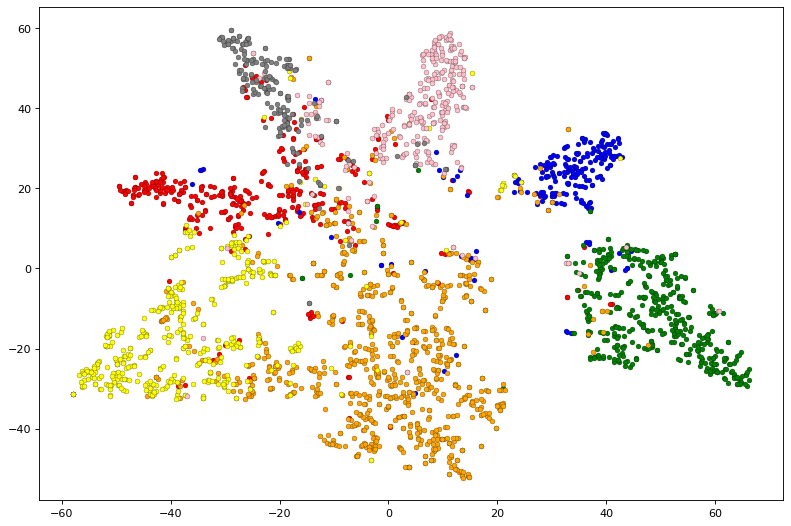

In [23]:
visualize_gat_properties()